# Experments
Timings reported in paper

In [19]:
%load_ext rpy2.ipython

from IPython.display import Image
from graphviz import Digraph
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('ticks')
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [20]:
%%R
# install.packages("matrixdist")
#install.packages("expm")
#install.packages("PhaseTypeR")

NULL


In [21]:
%%R
library(PhaseTypeR)
library(matrixdist)
library(expm)

In [22]:
%%R
devtools::install_github("TobiasRoikjer/PtDAlgorithms")
library(ptdalgorithms)

set.seed(7)

R[write to console]: Skipping install of 'ptdalgorithms' from a github remote, the SHA1 (29809aeb) has not changed since last install.
  Use `force = TRUE` to force installation



Function for plotting running times:

## TODO

Tested each method in matrixdist and found R_eigen to be fastest

- Properties 
    - Acyclic vs inversion
        - (replaces acyclic build vs naive inversion vs R_eigen matrixdist inversion)
    - Construction
        - C vs R
- Prectical use cases
    - Moments
        - Running time in seconds to compute 100 moments after computing the moment graph once (with one reward transform for each): ptdalgorithms, phasetyper, matrixdist
    - Distribution
        - Distribution context to 0.99
        - CDF five points for ptdalgorithms, phasetyper (uses expm), matrixdist


In [23]:
def runtime_plot(plot_df, x_labels, y_label, hue_label, colors=['#FF0000', '#2901F7'], legend=True, legend_title=True):
    with sns.color_palette(colors):
        gs_kw = dict(height_ratios=[50] + [1]*(len(x_labels)-1))
        fig, axes = plt.subplots(len(x_labels), 1, figsize=(5, 5), gridspec_kw=gs_kw)

        sns.scatterplot(data=plot_df, x=x_labels[0], y=y_label, hue=hue_label, legend=False, ax=axes[0])    
        ax = sns.lineplot(data=plot_df, x=x_labels[0], y='seconds', hue=hue_label, style=hue_label, ax=axes[0])
        # ax.set_yscale('log')

        if not legend_title:
            legend = axes[0].legend()
            legend.set_title("")
        
        leg = ax.get_legend()
        leg.get_frame().set_linewidth(0.0)
        
        if not legend:
            axes[0].get_legend().remove()

        sns.despine()

        for i in range(1, len(x_labels)):
            ax = sns.scatterplot(data=plot_df, x=x_labels[i], y=y_label, hue=hue_label, legend=False, ax=axes[i], alpha=0) 
            axes[i].get_yaxis().set_visible(False)
        plt.tight_layout()
    return fig, axes

## Rabbits

In [24]:
%%R
construct_rabbit_graph_R <- function(number_of_rabbits, flooding_rate_l, flooding_rate_r) {
    # We represent the vector as two integers, the number of rabbits on the left and right island
    state_vector_length <- 2
    graph <- create_graph(state_vector_length)
    initial_state <- c(number_of_rabbits, 0)
    # The initial state is the only starting state, with 100% starting probability
    add_edge(
      starting_vertex(graph),
      find_or_create_vertex(graph, initial_state),
      1
    )
    index <- 2
    # Iterate over all unvisited vertices
    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)
      state <- vertex$state
      if (state[1] > 0) {
        # Rabbit jump left to right
        child_state <- c(state[1] - 1, state[2] + 1)
        add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          1
        )

        # Left island flooding
        child_state <- c(0, state[2])
        add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          flooding_rate_l
        )
      }

      if (state[2] > 0) {
        # Rabbit jump right to left
        child_state <- c(state[1] + 1, state[2] - 1)
        add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          1
        )
        # Right island flooding with rate of 4
        child_state <- c(state[1], 0)
        add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          flooding_rate_r
        )
      }
      index <- index + 1
    }
    return(graph)
}

In [25]:
%%R
Rcpp::sourceCpp("./cpp/rabbit_construction.cpp")

### R vs C graph construction time 

In [26]:
%%R -o construction_df
RABBIT_NUMBERS <- c(10, 100, 200, 300, 400, 500, 600)#, 700, 800, 900, 1000, 1100, 1200, 1300,1400,1500)
construction_df <- data.frame()

for (i in 1:9) {
    for (rabbits in RABBIT_NUMBERS) {
        time_R <- NA
        if (rabbits <= 500) {
            start <- proc.time()[3]            
            construct_rabbit_graph_R(rabbits, 2, 4)
            end <- proc.time()[3]
            time_R <- end-start
        } 
        
        start <- proc.time()[3]
        graph <- construct_rabbit_graph(rabbits, 2, 4)
        end <- proc.time()[3]
        time_c = end-start
        
        construction_df <- rbind(construction_df, list(rabbits=rabbits, time_c=time_c, time_R=time_R, 
                                                       vertices=vertices_length(graph), edges=number_of_edges(graph)))
    }
}

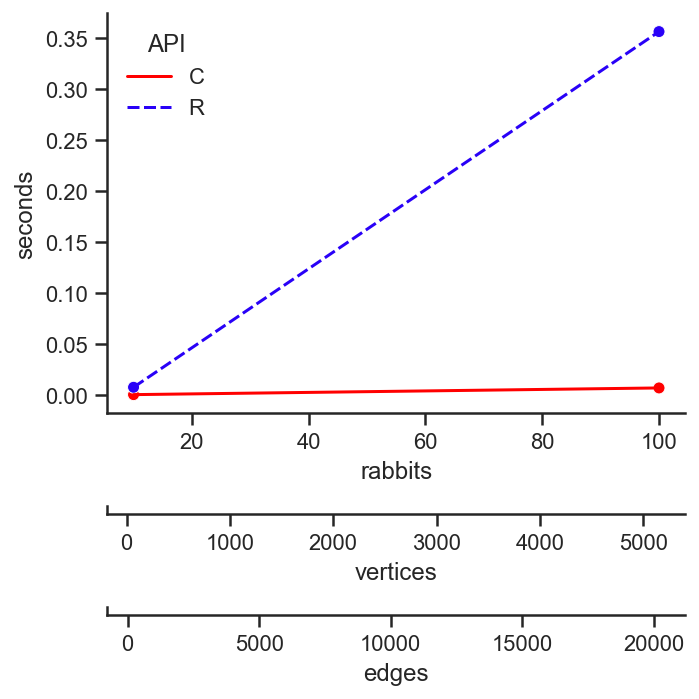

In [27]:
construction_df.loc[construction_df.time_R > 500, 'time_R'] = np.nan
plot_df = (construction_df.groupby(['rabbits', 'vertices', 'edges'])
 .agg('mean') 
 .reset_index()
 .rename(columns={'time_c': 'C', 'time_R': 'R'})
 .melt(id_vars=['rabbits', 'vertices', 'edges'], value_name='seconds', var_name='API')
)

runtime_plot(plot_df, ['rabbits', 'vertices', 'edges'], 'seconds', 'API')
#runtime_plot(plot_df, ['rabbits', 'vertices'], 'seconds', 'API')
plt.savefig('construction.pdf')

In [10]:
sparseness = 1 - ((construction_df.edges-construction_df.vertices)/((construction_df.vertices-1)**2))
np.mean(sparseness)

0.9949411304816265

### Expectation

In [54]:
%%R -o expectation_df
RABBIT_NUMBERS <- c(10, 20, 30, 40, 50, 60, 70, 80, 10, 100, 150, 200, 250)
expectation_df <- data.frame()

for (i in 1:9) {
    for (rabbits in RABBIT_NUMBERS) {
        graph <- construct_rabbit_graph(rabbits, 2, 4)
        
        phasetyper <- NA
        matrixdist_time <- NA
        ptdalgorithms_time <- NA
        if (rabbits <= 100) {
            M <- graph_as_matrix(graph)
            Y <- PH(M$SIM, M$IPV)

            start <- proc.time()[3]
            # solve(M$SIM)
            PhaseTypeR::mean(Y)
            end <- proc.time()[3]
            phasetyper_time <- end - start
            
            matrixdist_ph <- matrixdist::ph(M$IPV, M$SIM)
            start <- proc.time()[3]
            matrixdist::moment(matrixdist_ph, 1)
            stop <- proc.time()[3]
            matrixdist_time <- stop-start            
        }
        
        start <- proc.time()[3]
        expectation(graph)
        end <- proc.time()[3]
        ptdalgorithms_time = end-start
        expectation_df <- rbind(expectation_df, list(rabbits=rabbits, 
                                                     ptdalgorithms_time=ptdalgorithms_time, 
                                                     phasetyper_time=phasetyper_time,
                                                     matrixdist_time=matrixdist_time,
                                                     vertices=vertices_length(graph), 
                                                     edges=number_of_edges(graph)))
    }
}

INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

In [55]:
expectation_df

,rabbits,ptdalgorithms_time,phasetyper_time,matrixdist_time,vertices,edges
1,10.0,0.001,0.000,0.000,67,221
2,20.0,0.001,0.005,0.006,232,841
3,30.0,0.002,0.023,0.036,497,1861
4,40.0,0.004,0.063,0.101,862,3281
5,50.0,0.005,0.157,0.217,1327,5101
...,...,...,...,...,...,...
113,10.0,0.000,0.001,0.001,67,221
114,100.0,0.048,5.176,7.162,5152,20201
115,150.0,0.116,NaN,NaN,11477,45301
116,200.0,0.256,NaN,NaN,20302,80401


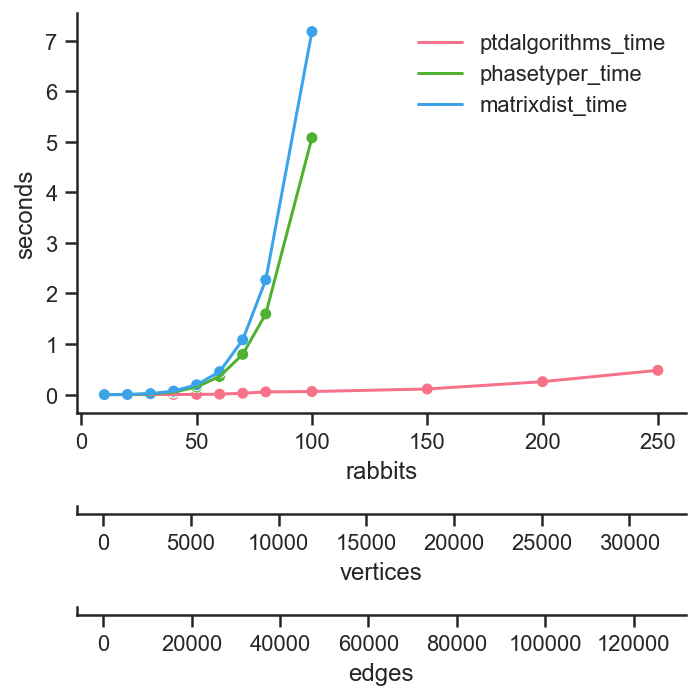

In [56]:
plot_df = (expectation_df.groupby(['rabbits', 'vertices', 'edges'])
 .agg('mean') 
 .reset_index()
# .rename(columns={'time': 'PtDAlgorithms (graph)', 'matrix_time': 'PhaseTypeR (matrices)'})
 .melt(id_vars=['rabbits', 'vertices', 'edges'], value_name='seconds', var_name='Representation')
)
runtime_plot(plot_df, ['rabbits', 'vertices', 'edges'], 'seconds', 'Representation',
            legend_title=False)
plt.savefig('expectation.pdf')

### CDF five vals

In [15]:
%%R -o rabbit_cdf_fivevals
RABBIT_NUMBERS <- c(10, 50)#, 100, 150, 200)
rabbit_cdf_fivevals <- data.frame()

for (i in 1:9) {
    for (rabbits in RABBIT_NUMBERS) {
        graph <- construct_rabbit_graph(rabbits, 2, 4)
        start <- proc.time()[3]
        ptdcdf <- ptdalgorithms::pph(c(1, 2, 3, 4, 5), graph)
        stop <- proc.time()[3]
        ptdalgorithm_time <- stop - start

        M <- graph_as_matrix(graph)
        
        start <- proc.time()[3]
        Y <- PH(M$SIM, M$IPV)
        pPH(c(1, 2, 3, 4, 5), Y)
        stop <- proc.time()[3]
        phasetyper_time <- stop - start
    
        matrixdist_ph <- ph(M$IPV, M$SIM)
        start <- proc.time()[3]
        mdcdf <- matrixdist::cdf(matrixdist_ph, c(1,2,3,4,5))
        stop <- proc.time()[3]
        matrixdist_time <- stop - start

        SIM <- M$SIM
        start <- proc.time()[3]
        expm(SIM*5, method="R_Eigen")
        stop <- proc.time()[3]
        expm_time <- stop - start
        
        rabbit_cdf_fivevals <- rbind(rabbit_cdf_fivevals, list(rabbits=rabbits, 
                                                 ptdalgorithm_time=ptdalgorithm_time,
                                                 phasetyper_time=phasetyper_time,
                                                 matrixdist_time=matrixdist_time,
                                                 # expm_time=expm_time,
                                                 vertices=vertices_length(graph), 
                                                 edges=number_of_edges(graph)))
    }
}

In [16]:
rabbit_cdf_fivevals

,rabbits,ptdalgorithm_time,phasetyper_time,matrixdist_time,vertices,edges
1,10.0,0.009,0.014,0.013,67,221
2,50.0,0.210,4.223,3.192,1327,5101
3,10.0,0.009,0.010,0.004,67,221
4,50.0,0.194,4.166,2.911,1327,5101
5,10.0,0.009,0.010,0.007,67,221
6,50.0,0.192,4.162,2.920,1327,5101
7,10.0,0.009,0.010,0.005,67,221
8,50.0,0.200,4.138,3.076,1327,5101
9,10.0,0.009,0.010,0.006,67,221
10,50.0,0.193,4.057,3.312,1327,5101


### Higher moments: PtDAlgorithms

In [13]:
%%R -o highermoments_df
RABBIT_NUMBERS <- c(10, 50, 100, 150, 200)
highermoments_df <- data.frame()

for (i in 1:9) {
    for (rabbits in RABBIT_NUMBERS) {
        graph <- construct_rabbit_graph(rabbits, 2, 4)

        expectation(graph)
        start <- proc.time()[3]
        for (i in 1:100) {
            expectation(graph)
        }
        end <- proc.time()[3]
        time = end-start
        highermoments_df <- rbind(highermoments_df, list(rabbits=rabbits, time=time,
                                                         vertices=vertices_length(graph), 
                                                         edges=number_of_edges(graph)))
    }
}

INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

In [14]:
highermoments_df.head()

,rabbits,time,vertices,edges
1,10.0,0.001,67,221
2,50.0,0.015,1327,5101
3,100.0,0.135,5152,20201
4,150.0,0.423,11477,45301
5,200.0,0.897,20302,80401


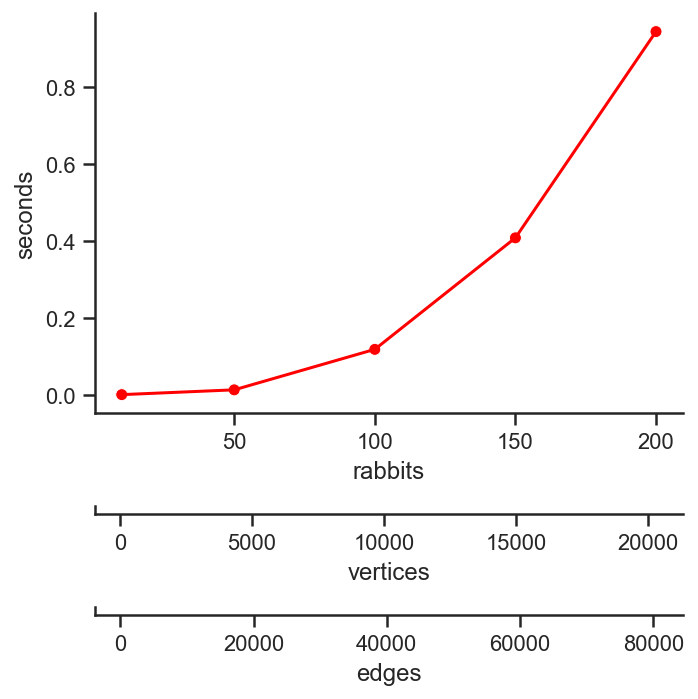

In [15]:
plot_df = (highermoments_df.groupby(['rabbits', 'vertices', 'edges'])
 .agg('mean') 
 .reset_index()
 .rename(columns={'time': 'graph', 'matrix_time': 'matrices'})
 .melt(id_vars=['rabbits', 'vertices', 'edges'], value_name='seconds', var_name='Representation')
)
runtime_plot(plot_df, ['rabbits', 'vertices', 'edges'], 'seconds', 'Representation', legend=False)
plt.savefig('highermoments.pdf')

### Explicit distribution context: PtDAlgorithms

In [16]:
%%R -o distcontext_df
RABBIT_NUMBERS <- c(10, 50, 100, 150, 200)
distcontext_df <- data.frame()

for (i in 1:9) {
    for (rabbits in RABBIT_NUMBERS) {
        graph <- construct_rabbit_graph(rabbits, 2, 4)

        start <- proc.time()[3]
        ctx <- distribution_context(graph, 10000)

        while (distribution_context_state(ctx)$cdf < 0.99) {
            distribution_context_step(ctx)
        }
        end <- proc.time()[3]
        time = end-start
        distcontext_df <- rbind(distcontext_df, list(rabbits=rabbits, time=time,
                                                     vertices=vertices_length(graph), 
                                                     edges=number_of_edges(graph)))
    }
}

In [17]:
distcontext_df.head()

,rabbits,time,vertices,edges
1,10.0,0.129,67,221
2,50.0,0.868,1327,5101
3,100.0,3.159,5152,20201
4,150.0,7.293,11477,45301
5,200.0,15.991,20302,80401


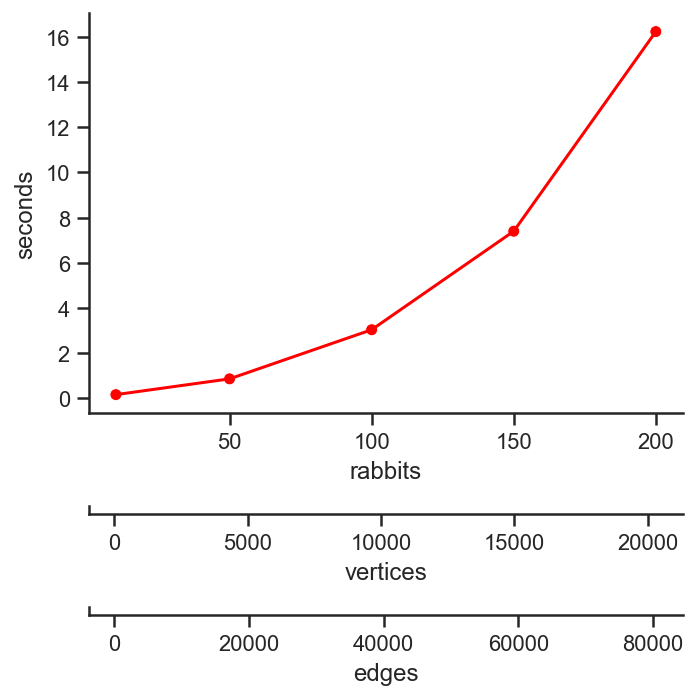

In [18]:
plot_df = (distcontext_df.groupby(['rabbits', 'vertices', 'edges'])
 .agg('mean') 
 .reset_index()
 .rename(columns={'time': 'graph', 'matrix_time': 'matrices'})
 .melt(id_vars=['rabbits', 'vertices', 'edges'], value_name='seconds', var_name='Representation')
)
runtime_plot(plot_df, ['rabbits', 'vertices', 'edges'], 'seconds', 'Representation', legend=False)
plt.savefig('distcontext.pdf')    

## Kingman

In [19]:
%%R
Rcpp::sourceCpp("./cpp/kingman.cpp")

ld: warning: -pie being ignored. It is only used when linking a main executable


### Expectation: PtDAlgorithms vs PhaseTypeR

In [20]:
%%R -o ours_vs_iker_expectation
results <- data.frame()
for (samples in c(5, 10, 15, 20, 25)){
    graph <- generate_kingman_graph(samples, samples)
    matrix_form <- graph_as_matrix(graph)
    
    start <- proc.time()[3]
    Y <- PH(matrix_form$SIM, matrix_form$IPV)
    mean <- PhaseTypeR::mean(Y)
    stop <- proc.time()[3]
    time_spent_mean_iker <- stop - start
    
    start <- proc.time()[3]
    mean <- ptdalgorithms::expectation(graph)
    stop <- proc.time()[3]
    time_spent_mean_ours <- stop - start
    
    results <- rbind(results, data.frame(samples=samples,vertices=vertices_length(graph),
                                         edges=number_of_edges(graph),
                                         time_spent_mean_iker=time_spent_mean_iker,
                                         time_spent_mean_ours=time_spent_mean_ours))
    cat(samples)
}
ours_vs_iker_expectation <- results

5101520

INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...


25

INFO: building reward compute graph...


In [21]:
ours_vs_iker_expectation.head()

,samples,vertices,edges,time_spent_mean_iker,time_spent_mean_ours
elapsed,5.0,8,10,0.000,0.000
elapsed1,10.0,43,115,0.000,0.000
elapsed2,15.0,177,739,0.003,0.000
elapsed3,20.0,628,3546,0.026,0.001
elapsed4,25.0,1959,13991,0.408,0.006


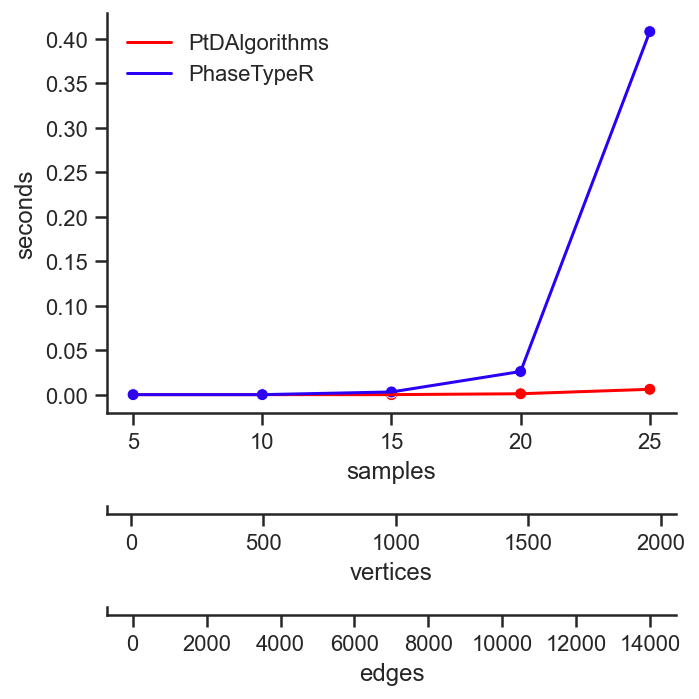

In [22]:
plot_df = (ours_vs_iker_expectation.groupby(['samples', 'vertices', 'edges'])
 .agg('mean') 
 .reset_index()
 .rename(columns={'time_spent_mean_iker': 'PhaseTypeR', 'time_spent_mean_ours': 'PtDAlgorithms'})
 .melt(id_vars=['samples', 'vertices', 'edges'], value_vars=['PtDAlgorithms', 'PhaseTypeR'],
       value_name='seconds', var_name='Method')
)
runtime_plot(plot_df, ['samples', 'vertices', 'edges'], 'seconds', 'Method', legend_title=False)
plt.savefig('ours_vs_iker_expectation.pdf')    

### CDF five vals: PtDAlgorithms vs PhaseTypeR

In [23]:
%%R -o ours_vs_iker_cdf5
results <- data.frame()
for (samples in c(5, 10, 15, 20, 25)){
    graph <- generate_kingman_graph(samples, samples)
    matrix_form <- graph_as_matrix(graph)
    
    start <- proc.time()[3]
    Y <- PH(matrix_form$SIM, matrix_form$IPV)
    pPH(c(1, 2, 3, 4, 5), Y)
    stop <- proc.time()[3]
    time_spent_pdf5_iker <- stop - start
    
    start <- proc.time()[3]
    ptdcdf <- ptdalgorithms::pph(c(1, 2, 3, 4, 5),graph)
    stop <- proc.time()[3]
    time_spent_pdf5_ours <- stop - start
    
    results <- rbind(results, data.frame(samples=samples,vertices=vertices_length(graph),
                                         edges=number_of_edges(graph),
                                         time_spent_pdf5_iker=time_spent_pdf5_iker,
                                         time_spent_pdf5_ours=time_spent_pdf5_ours))
    cat(samples)
}
ours_vs_iker_cdf5 <- results

510152025

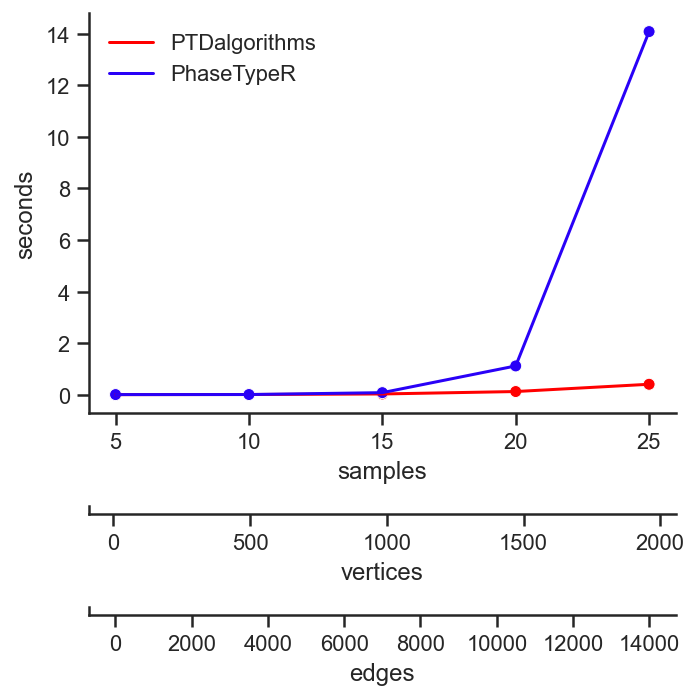

In [24]:
plot_df = (ours_vs_iker_cdf5.groupby(['samples', 'vertices', 'edges'])
 .agg('mean') 
 .reset_index()
 .rename(columns={'time_spent_pdf5_iker': 'PhaseTypeR', 'time_spent_pdf5_ours': 'PTDalgorithms'})
 .melt(id_vars=['samples', 'vertices', 'edges'], value_vars=['PTDalgorithms', 'PhaseTypeR'],
       value_name='seconds', var_name='Method')
)
runtime_plot(plot_df, ['samples', 'vertices', 'edges'], 'seconds', 'Method', legend_title=False)
plt.savefig('ours_vs_iker_cdf5.pdf')    

### Total branch length expectation: PtDAlgorithms vs matrixdist

In [25]:
%%R -o both_without_fifth_moments
# Computations WITHOUT fifth moments (takes a long time)
results <- data.frame()
for (samples in c(5, 10, 15, 20, 25)){
    # Call CPP function to generate graph
    start <- proc.time()[3]
    graph <- generate_kingman_graph(samples, samples)
    stop <- proc.time()[3]
    time_spent_construction_cpp <- stop - start
    # Reward transform into Ttotal
    # I know we could just use without 'tons making the graph smaller
    # but that is the whole purpose of this
    graph <- reward_transform(graph, rowSums(states(graph)))
    start <- proc.time()[3]
    expectation(graph)
    stop <- proc.time()[3]
    time_spent_reward_graph <- stop - start

    PH <- graph_as_matrix(graph)
    matrixdist_ph <- ph(PH$IPV, PH$SIM)
    start <- proc.time()[3]
    matrixdist::moment(matrixdist_ph, 1)
    stop <- proc.time()[3]
    time_spent_1_moment_md <- stop-start
    results <- rbind(results, data.frame(samples=samples,vertices=vertices_length(graph),edges=number_of_edges(graph),time_spent_1_moment_md=time_spent_1_moment_md,time_spent_reward_graph=time_spent_reward_graph,time_spent_construction_cpp=time_spent_construction_cpp))
    cat(samples)
}

both_without_fifth_moments <- results

5101520

INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...


25

In [26]:
both_without_fifth_moments['one_moment_ptd'] = both_without_fifth_moments.time_spent_reward_graph	 + both_without_fifth_moments.time_spent_reward_graph

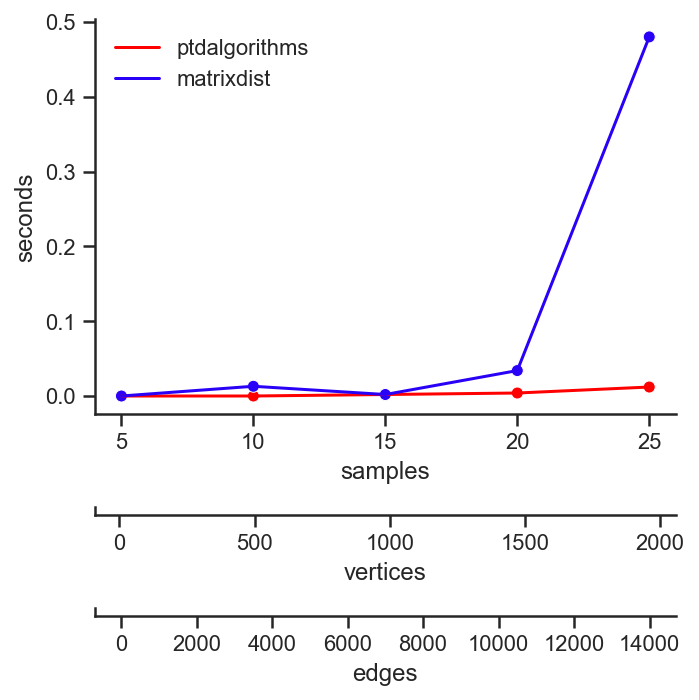

In [27]:
plot_df = (both_without_fifth_moments.groupby(['samples', 'vertices', 'edges'])
 .agg('mean') 
 .reset_index()
 .rename(columns={'one_moment_ptd': 'ptdalgorithms', 'time_spent_1_moment_md': 'matrixdist'})
 .melt(id_vars=['samples', 'vertices', 'edges'], value_vars=['ptdalgorithms', 'matrixdist'],
       value_name='seconds', var_name='Method')
)
runtime_plot(plot_df, ['samples', 'vertices', 'edges'], 'seconds', 'Method',
            legend_title=False)
plt.savefig('both_without_fifth_moments.pdf')    

### Total branch length five moments: PtDAlgorithms vs matrixdist

In [28]:
%%R -o both_with_fifth_moments
# Computations with fifth moments (takes a long time)
results <- data.frame()
for (samples in c(5, 10, 15, 20, 25)){
    #for (samples in c(5)){
    # Call CPP function to generate graph
    start <- proc.time()[3]
    graph <- generate_kingman_graph(samples, samples)
    stop <- proc.time()[3]
    time_spent_construction_cpp <- stop - start
    # Reward transform into Ttotal
    # I know we could just use without 'tons making the graph smaller
    # but that is the whole purpose of this
    graph <- reward_transform(graph, rowSums(states(graph)))
    start <- proc.time()[3]
    expectation(graph)
    stop <- proc.time()[3]
    time_spent_reward_graph <- stop - start
    start <- proc.time()[3]
    moments(graph, 5)
    stop <- proc.time()[3]
    time_spent_fifth_moment <- stop - start
    
    PH <- graph_as_matrix(graph)
    matrixdist_ph <- ph(PH$IPV, PH$SIM)
    start <- proc.time()[3]
    matrixdist::moment(matrixdist_ph, 1)
    stop <- proc.time()[3]
    time_spent_1_moment_md <- stop-start
    start <- proc.time()[3]
    matrixdist::moment(matrixdist_ph, 5)
    stop <- proc.time()[3]
    time_spent_fifth_moment_md <- stop-start
    results <- rbind(results, data.frame(samples=samples,vertices=vertices_length(graph),edges=number_of_edges(graph),time_spent_fifth_moment_md=time_spent_fifth_moment_md,time_spent_1_moment_md=time_spent_1_moment_md,time_spent_fifth_moment=time_spent_fifth_moment,time_spent_reward_graph=time_spent_reward_graph,time_spent_construction_cpp=time_spent_construction_cpp))
    cat(samples)
}

both_with_fifth_moments <- results

5101520

INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...


25

In [29]:
both_with_fifth_moments['five_moments_ptd'] = both_with_fifth_moments.time_spent_fifth_moment + both_with_fifth_moments.time_spent_reward_graph

In [30]:
sparseness = 1 - ((both_with_fifth_moments.edges-both_with_fifth_moments.vertices)/((both_with_fifth_moments.vertices-1)**2))
np.mean(sparseness)

0.9779326676839663

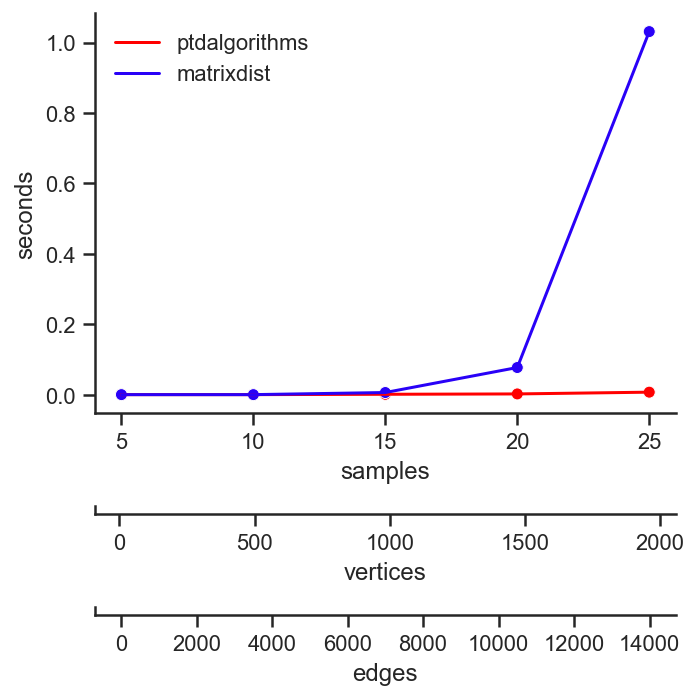

In [31]:
plot_df = (both_with_fifth_moments.groupby(['samples', 'vertices', 'edges'])
 .agg('mean') 
 .reset_index()
 .rename(columns={'five_moments_ptd': 'ptdalgorithms', 'time_spent_fifth_moment_md': 'matrixdist'})
 .melt(id_vars=['samples', 'vertices', 'edges'], value_vars=['ptdalgorithms', 'matrixdist'],
       value_name='seconds', var_name='Method')
)
runtime_plot(plot_df, ['samples', 'vertices', 'edges'], 'seconds', 'Method',
            legend_title=False)
plt.savefig('distcontext.pdf')    

### Total branch length five moments: only PtDAlgorithms

In [32]:
%%R -o ours_with_fifth_moments
# Computations with fifth moments but only for OUR algorithms as matrixdist takes TOO LONG
results <- data.frame()
for (samples in c(5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55)){
# Call CPP function to generate graph
start <- proc.time()[3]
graph <- generate_kingman_graph(samples, samples)
stop <- proc.time()[3]
time_spent_construction_cpp <- stop - start
# Reward transform into Ttotal
# I know we could just use without 'tons making the graph smaller
# but that is the whole purpose of this
graph <- reward_transform(graph, rowSums(states(graph)))
start <- proc.time()[3]
expectation(graph)
stop <- proc.time()[3]
time_spent_reward_graph <- stop - start

start <- proc.time()[3]
moments(graph, 5)
stop <- proc.time()[3]
time_spent_fifth_moment <- stop - start
results <- rbind(results, data.frame(samples=samples,vertices=vertices_length(graph),edges=number_of_edges(graph),time_spent_fifth_moment=time_spent_fifth_moment,time_spent_reward_graph=time_spent_reward_graph,time_spent_construction_cpp=time_spent_construction_cpp))
cat(samples)
}

ours_with_fifth_moments <- results

51015202530

INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...


35

INFO: building reward compute graph...


40

INFO: building reward compute graph...
INFO: building reward compute graph...


45

INFO: building reward compute graph...


50

INFO: building reward compute graph...


55

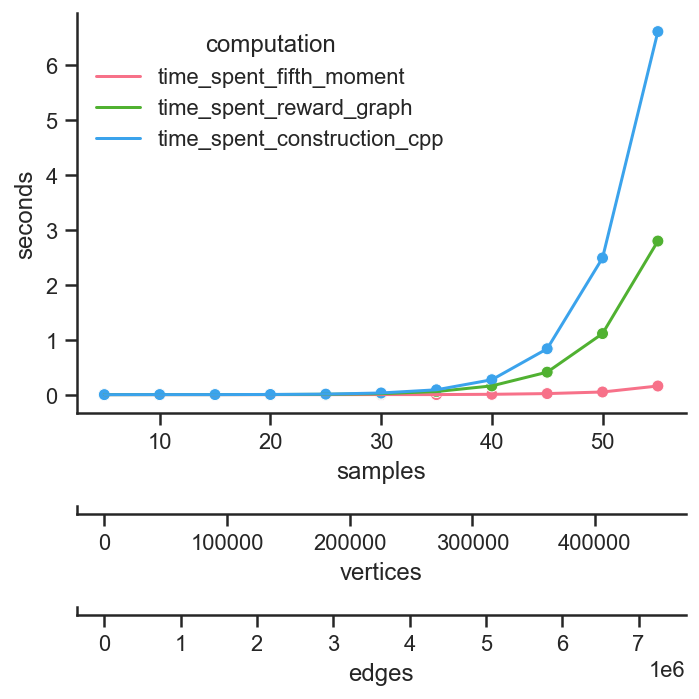

In [33]:
plot_df = (ours_with_fifth_moments.groupby(['samples', 'vertices', 'edges'])
 .agg('mean') 
 .reset_index()
 # .rename(columns={'one_moment_ptd': 'ptdalgorithms', 'time_spent_1_moment_md': 'matrixdist'})
 .melt(id_vars=['samples', 'vertices', 'edges'], 
       value_name='seconds', var_name='computation')
)
runtime_plot(plot_df, ['samples', 'vertices', 'edges'], 'seconds', 'computation')
plt.savefig('ours_with_fifth_moments.pdf')    

### CDF five vals: PtDAlgorithms vs. matrixdist

In [34]:
%%R -o both_distribution_functions
# Distribution functions
# Compute CDF for 1,2,3,4,5 time
results <- data.frame()
for (samples in c(5, 10, 15, 20, 25)){
# Call CPP function to generate graph
start <- proc.time()[3]
graph <- generate_kingman_graph(samples, samples)
stop <- proc.time()[3]
time_spent_construction_cpp <- stop - start
# Reward transform into Ttotal
# I know we could just use without 'tons making the graph smaller
# but that is the whole purpose of this
graph <- reward_transform(graph, rowSums(states(graph)))
start <- proc.time()[3]
ptdcdf <- ptdalgorithms::pph(c(1, 2, 3, 4, 5),graph)
stop <- proc.time()[3]
time_spent_cdf <- stop - start

PH <- graph_as_matrix(graph)
matrixdist_ph <- ph(PH$IPV, PH$SIM)
start <- proc.time()[3]
mdcdf <- matrixdist::cdf(matrixdist_ph, c(1,2,3,4,5))
stop <- proc.time()[3]
time_spent_cdf_md <- stop - start
results <- rbind(results, data.frame(samples=samples,vertices=vertices_length(graph),edges=number_of_edges(graph),
                                     time_spent_cdf_md=time_spent_cdf_md,
                                     time_spent_cdf=time_spent_cdf,
                                     cdf5_md=mdcdf[5],
                                     cdf5=ptdcdf[5],
                                     time_spent_construction_cpp=time_spent_construction_cpp))
cat(samples)
}

both_distribution_functions <- results

510152025

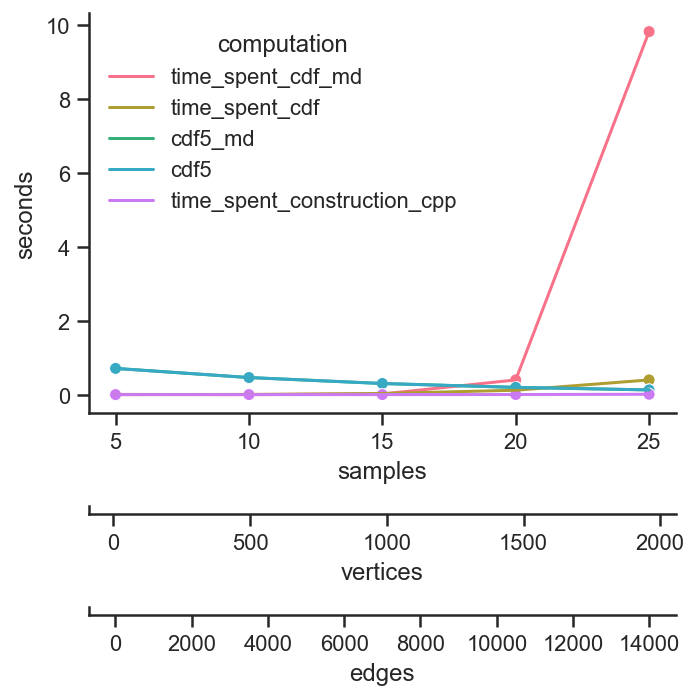

In [35]:
plot_df = (both_distribution_functions.groupby(['samples', 'vertices', 'edges'])
 .agg('mean') 
 .reset_index()
 # .rename(columns={'one_moment_ptd': 'ptdalgorithms', 'time_spent_1_moment_md': 'matrixdist'})
 .melt(id_vars=['samples', 'vertices', 'edges'], 
       value_name='seconds', var_name='computation')
)
runtime_plot(plot_df, ['samples', 'vertices', 'edges'], 'seconds', 'computation')
plt.savefig('both_distribution_functions.pdf')    

### Total branch length five moments: only PtDAlgorithms

In [36]:
%%R -o ours_distribution_functions
# Distribution functions JUST US
#Comput CDF for 1,2,3,4,5 time
results <- data.frame()
for (samples in c(5, 10, 15, 20, 25, 30, 35, 40)){
    # Call CPP function to generate graph
    start <- proc.time()[3]
    graph <- generate_kingman_graph(samples, samples)
    stop <- proc.time()[3]
    time_spent_construction_cpp <- stop - start
    # Reward transform into Ttotal
    # I know we could just use without 'tons making the graph smaller
    # but that is the whole purpose of this
    graph <- reward_transform(graph, rowSums(states(graph)))
    start <- proc.time()[3]
    ptdcdf <- ptdalgorithms::pph(c(1,2,3,4,5),graph)
    stop <- proc.time()[3]
    time_spent_cdf <- stop - start

    results <- rbind(results, data.frame(samples=samples,vertices=vertices_length(graph),edges=number_of_edges(graph),
                                         time_spent_cdf=time_spent_cdf,
                                         #cdf5=ptdcdf,
                                         time_spent_construction_cpp=time_spent_construction_cpp))
    cat(samples)
}

ours_distribution_functions <- results
#plot(results$edges, results$time_spent_cdf)

510152025303540

In [37]:
ours_distribution_functions.head()

,samples,vertices,edges,time_spent_cdf,cdf5,time_spent_construction_cpp
1,5.0,8,10,0.001,0.023903,0.0
2,5.0,8,10,0.001,0.159594,0.0
3,5.0,8,10,0.001,0.364266,0.0
4,5.0,8,10,0.001,0.559064,0.0
5,5.0,8,10,0.001,0.710034,0.0


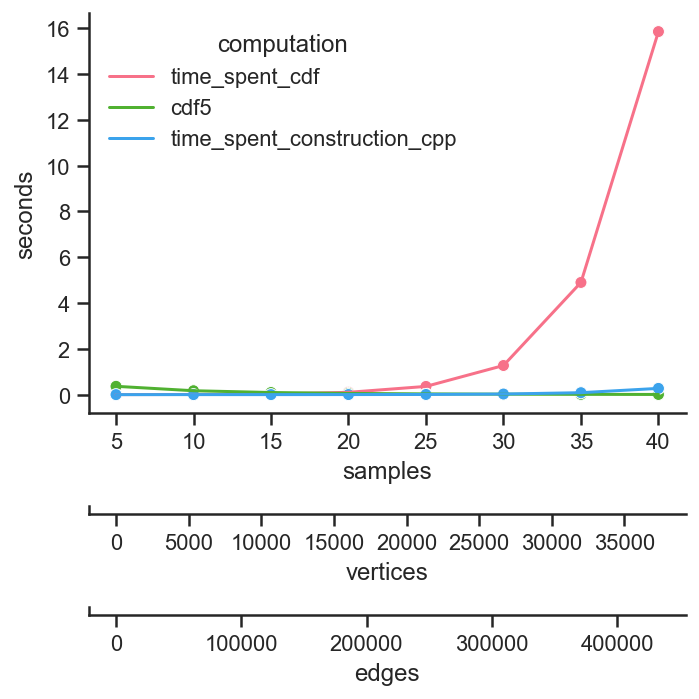

In [38]:
plot_df = (ours_distribution_functions.groupby(['samples', 'vertices', 'edges'])
 .agg('mean') 
 .reset_index()
 # .rename(columns={'one_moment_ptd': 'ptdalgorithms', 'time_spent_1_moment_md': 'matrixdist'})
 .melt(id_vars=['samples', 'vertices', 'edges'], 
       value_name='seconds', var_name='computation')
)
runtime_plot(plot_df, ['samples', 'vertices', 'edges'], 'seconds', 'computation')
plt.savefig('ours_distribution_functions.pdf')    

### Exponentiation: expm all methods

In [39]:
%%R -o expm_tests_all_methods
#EXPM  tests, ALL methods!

results <- data.frame()
for (samples in c(5, 10, 15, 21)){
  for (method in c("Higham08.b", "Higham08",
                   "AlMohy-Hi09",
                   "Ward77", "PadeRBS", "Pade", "Taylor", "PadeO", "TaylorO",
                   "R_Eigen", "R_Pade", "R_Ward77", "hybrid_Eigen_Ward")) {
# Call CPP function to generate graph
start <- proc.time()[3]
graph <- generate_kingman_graph(samples, samples)
stop <- proc.time()[3]
time_spent_construction_cpp <- stop - start
# Reward transform into Ttotal
# I know we could just use without 'tons making the graph smaller
# but that is the whole purpose of this
graph <- reward_transform(graph, rowSums(states(graph)))
mat <- graph_as_matrix(graph)$SIM
start <- proc.time()[3]
expm(mat*5, method=method) # NB: Why times 5 ??????????
stop <- proc.time()[3]
time_spent_exp <- stop - start

results <- rbind(results, data.frame(samples=samples,vertices=vertices_length(graph),edges=number_of_edges(graph),time_spent_exp=time_spent_exp, method=method))

cat(method, ' ')
  }
cat(samples)
}

expm_tests_all_methods <- results

Higham08.b  Higham08  AlMohy-Hi09  Ward77  PadeRBS  Pade  Taylor  PadeO  TaylorO  R_Eigen  R_Pade  R_Ward77  hybrid_Eigen_Ward  5Higham08.b  Higham08  AlMohy-Hi09  Ward77  PadeRBS  Pade  Taylor  PadeO  TaylorO  R_Eigen  R_Pade  R_Ward77  hybrid_Eigen_Ward  10Higham08.b  Higham08  AlMohy-Hi09  Ward77  PadeRBS  Pade  Taylor  PadeO  TaylorO  R_Eigen  R_Pade  R_Ward77  hybrid_Eigen_Ward  15Higham08.b  Higham08  AlMohy-Hi09  Ward77  PadeRBS  Pade  Taylor  PadeO  TaylorO  R_Eigen  R_Pade  R_Ward77  hybrid_Eigen_Ward  21

In [40]:
expm_tests_all_methods.head()

,samples,vertices,edges,time_spent_exp,method
elapsed,5.0,8,10,0.000,Higham08.b
elapsed1,5.0,8,10,0.001,Higham08
elapsed2,5.0,8,10,0.001,AlMohy-Hi09
elapsed3,5.0,8,10,0.002,Ward77
elapsed4,5.0,8,10,0.001,PadeRBS


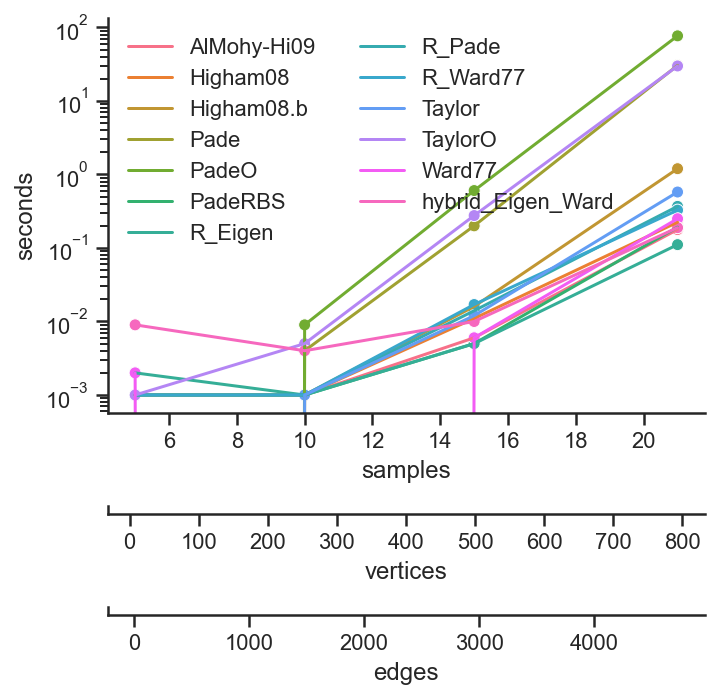

In [41]:
plot_df = (expm_tests_all_methods.groupby(['samples', 'vertices', 'edges', 'method'])
 .agg('mean') 
 .reset_index()
 .rename(columns={'time_spent_exp': 'seconds'})
 # .melt(id_vars=['samples', 'vertices', 'edges'], value_vars=['time_spent_exp'],
 #       value_name='seconds', var_name='computation')
)
fig, axes = runtime_plot(plot_df, ['samples', 'vertices', 'edges'], 'seconds', 'method')
axes[0].legend(ncol=2, loc="upper left", framealpha=0)
axes[0].set_yscale('log')
plt.savefig('expm_tests_all_methods.pdf')    

### Exponentiation: expm best methods

In [42]:
%%R -o expm_tests_best_methods
#EXPM  tests, BEST methods!
library(expm)

results <- data.frame()
for (samples in c(5, 10, 15, 20, 25)){
  for (method in c("R_Eigen", "Higham08.b", "Higham08", "hybrid_Eigen_Ward")) {
# Call CPP function to generate graph
start <- proc.time()[3]
graph <- generate_kingman_graph(samples, samples)
stop <- proc.time()[3]
time_spent_construction_cpp <- stop - start
# Reward transform into Ttotal
# I know we could just use without 'tons making the graph smaller
# but that is the whole purpose of this
graph <- reward_transform(graph, rowSums(states(graph)))
mat <- graph_as_matrix(graph)$SIM
start <- proc.time()[3]
expm(mat*5, method=method)
stop <- proc.time()[3]
time_spent_exp <- stop - start

results <- rbind(results, data.frame(samples=samples,vertices=vertices_length(graph),edges=number_of_edges(graph),time_spent_exp=time_spent_exp, method=method))
cat(method)
  }
cat(samples)
}

expm_tests_best_methods <- results

R_EigenHigham08.bHigham08hybrid_Eigen_Ward5R_EigenHigham08.bHigham08hybrid_Eigen_Ward10R_EigenHigham08.bHigham08hybrid_Eigen_Ward15R_EigenHigham08.bHigham08hybrid_Eigen_Ward20R_EigenHigham08.bHigham08hybrid_Eigen_Ward25

In [43]:
expm_tests_best_methods.head()

,samples,vertices,edges,time_spent_exp,method
elapsed,5.0,8,10,0.000,R_Eigen
elapsed1,5.0,8,10,0.001,Higham08.b
elapsed2,5.0,8,10,0.000,Higham08
elapsed3,5.0,8,10,0.001,hybrid_Eigen_Ward
elapsed4,10.0,43,115,0.001,R_Eigen


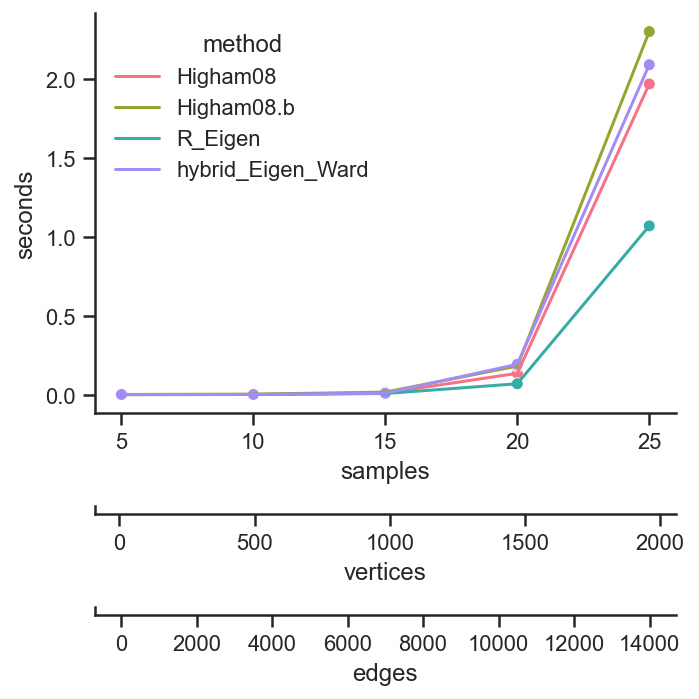

In [44]:
plot_df = (expm_tests_best_methods.groupby(['samples', 'vertices', 'edges', 'method'])
 .agg('mean') 
 .reset_index()
 .rename(columns={'time_spent_exp': 'seconds'})
)
runtime_plot(plot_df, ['samples', 'vertices', 'edges'], 'seconds', 'method')
plt.savefig('expm_tests_best_methods.pdf') 

### Exponentiation: expm R_Eigen

In [45]:
%%R -o expm_tests_R_Eigen
#EXPM  tests, BEST method which is R_eigen!!
library(expm)

results <- data.frame()
for (samples in c(5, 10, 15, 20, 25, 30)){

    # Call CPP function to generate graph
    start <- proc.time()[3]
    graph <- generate_kingman_graph(samples, samples)
    stop <- proc.time()[3]
    time_spent_construction_cpp <- stop - start
    # Reward transform into Ttotal
    # I know we could just use without 'tons making the graph smaller
    # but that is the whole purpose of this

    start <- proc.time()[3]
    graph <- reward_transform(graph, rowSums(states(graph)))
    ptdcdf <- ptdalgorithms::pph(c(1, 2, 3, 4, 5),graph)
    stop <- proc.time()[3]
    time_spent_ptd <- stop - start


    mat <- graph_as_matrix(graph)$SIM

    start <- proc.time()[3]
    expm(mat*5, method="R_Eigen")
    stop <- proc.time()[3]
    time_spent_exp <- stop - start


    results <- rbind(results, data.frame(samples=samples,vertices=vertices_length(graph),
                                         edges=number_of_edges(graph),
                                         time_spent_exp=time_spent_exp, 
                                         time_spent_ptd=time_spent_ptd
                                         ))

cat(samples)
}

expm_tests_R_Eigen <- results

51015202530

In [46]:
expm_tests_R_Eigen.head()

,samples,vertices,edges,time_spent_exp,time_spent_ptd
elapsed,5.0,8,10,0.000,0.001
elapsed1,10.0,43,115,0.001,0.007
elapsed2,15.0,177,739,0.005,0.032
elapsed3,20.0,628,3546,0.064,0.126
elapsed4,25.0,1959,13991,1.150,0.407


In [47]:
plot_df = (expm_tests_R_Eigen.groupby(['samples', 'vertices', 'edges'])
 .agg('mean') 
 .reset_index()
 .rename(columns={'time_spent_exp': 'seconds'})
          )
plot_df

,samples,vertices,edges,seconds,time_spent_ptd
0,5.0,8,10,0.000,0.001
1,10.0,43,115,0.001,0.007
2,15.0,177,739,0.005,0.032
3,20.0,628,3546,0.064,0.126
4,25.0,1959,13991,1.150,0.407
5,30.0,5605,48298,20.356,1.308


In [48]:
plot_df = (expm_tests_R_Eigen.groupby(['samples', 'vertices', 'edges'])
 .agg('mean') 
 .reset_index()
 .rename(columns={'time_spent_exp': 'R_eigen', 'time_spent_ptd': 'PtDAlgorithms'})
 .melt(id_vars=['samples', 'vertices', 'edges'], 
       value_name='seconds', var_name='computation')
)
plot_df

,samples,vertices,edges,computation,seconds
0,5.0,8,10,R_eigen,0.000
1,10.0,43,115,R_eigen,0.001
2,15.0,177,739,R_eigen,0.005
3,20.0,628,3546,R_eigen,0.064
4,25.0,1959,13991,R_eigen,1.150
5,30.0,5605,48298,R_eigen,20.356
6,5.0,8,10,PtDAlgorithms,0.001
7,10.0,43,115,PtDAlgorithms,0.007
8,15.0,177,739,PtDAlgorithms,0.032
9,20.0,628,3546,PtDAlgorithms,0.126


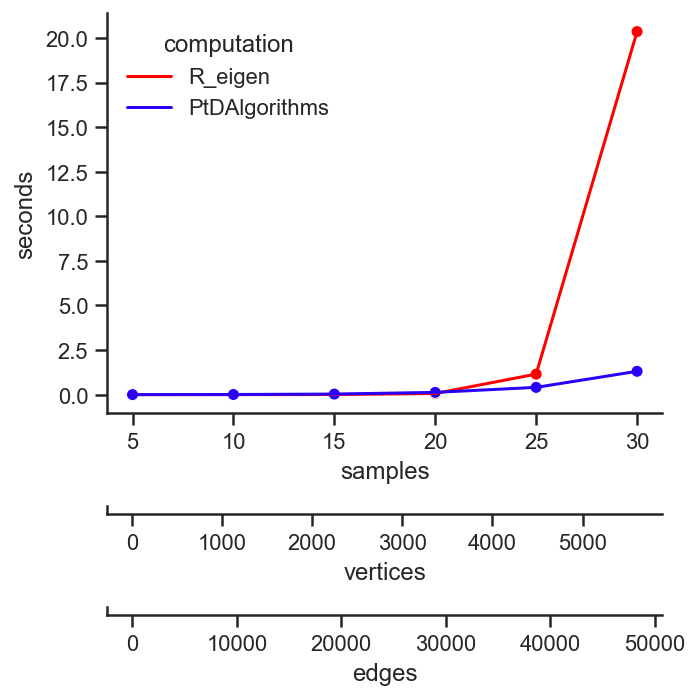

In [49]:
runtime_plot(plot_df, ['samples', 'vertices', 'edges'], 'seconds', 'computation')
plt.savefig('expm_tests_R_Eigen.pdf') 

In [30]:
%%R
# Make simple coxian distribution
M <- matrixdist::ph(structure="coxian",dimension=10)@pars$S

graph <- create_graph(1)
s <- create_vertex(graph,1)
a <- create_vertex(graph,1)
add_edge(starting_vertex(graph),s , 1)
set.seed(1234)
for (i in 1:10) {n <- create_vertex(graph, 1); k <- runif(1); l <- runif(1) * k; add_edge(n,s,k); add_edge(n,a,l);s <- n}
graph_as_matrix(graph)

$states
      [,1]
 [1,]    1
 [2,]    1
 [3,]    1
 [4,]    1
 [5,]    1
 [6,]    1
 [7,]    1
 [8,]    1
 [9,]    1
[10,]    1

$SIM
            [,1]       [,2]       [,3]       [,4]       [,5]       [,6]
 [1,] -0.2300847  0.1867228  0.0000000  0.0000000  0.0000000  0.0000000
 [2,]  0.0000000 -0.3625936  0.2862233  0.0000000  0.0000000  0.0000000
 [3,]  0.0000000  0.0000000 -0.5370706  0.2923158  0.0000000  0.0000000
 [4,]  0.0000000  0.0000000  0.0000000 -0.5438192  0.2827336  0.0000000
 [5,]  0.0000000  0.0000000  0.0000000  0.0000000 -1.0715811  0.6935913
 [6,]  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 -1.0086181
 [7,]  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
 [8,]  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
 [9,]  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
[10,]  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
            [,7]         [,8]       [,9]      [,10]
 [1,]  0.0000000  0.0